# Setup

In [97]:
# https://openalex.org/

from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders
import pyalex
pyalex.config.email = "maximilian.noichl@uni-bamberg.de"
import time
from itertools import chain
import tqdm.auto as tqdm
import pandas as pd
from compress_pickle import dump, load
import networkx as nx
import json
import numpy as np
import seaborn as sns


# Get Perceptron Data

In [83]:
query = Works().search(['Perceptron']).filter(publication_year="<1979")
records= []
for record in chain(*query.paginate(per_page=200,n_max=None)):
    records.append(record)
    #print(len(records))



In [84]:
df = pd.DataFrame(records)
print(len(df))
print(df.columns)
print(df['authorships'][0])
print(df['referenced_works'][0])

701
Index(['id', 'doi', 'title', 'display_name', 'relevance_score',
       'publication_year', 'publication_date', 'ids', 'language',
       'primary_location', 'type', 'type_crossref', 'indexed_in',
       'open_access', 'authorships', 'countries_distinct_count',
       'institutions_distinct_count', 'corresponding_author_ids',
       'corresponding_institution_ids', 'apc_list', 'apc_paid', 'has_fulltext',
       'fulltext_origin', 'cited_by_count', 'cited_by_percentile_year',
       'biblio', 'is_retracted', 'is_paratext', 'primary_topic', 'topics',
       'keywords', 'concepts', 'mesh', 'locations_count', 'locations',
       'best_oa_location', 'sustainable_development_goals', 'grants',
       'datasets', 'versions', 'referenced_works_count', 'referenced_works',
       'related_works', 'ngrams_url', 'abstract_inverted_index',
       'cited_by_api_url', 'counts_by_year', 'updated_date', 'created_date'],
      dtype='object')
[{'author_position': 'first', 'author': {'id': 'https://ope

# Network of Articles

In [85]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
for ix,item in df.iterrows():
    G.add_node(item["id"])  # Add each work as a node
    for related in item["related_works"]:
        G.add_edge(item["id"], related)  # Create an edge from this work to each related work

# Optionally, you can print the nodes and edges to verify
print("Nodes in the network:")
print(len(G.nodes()))
print("Edges in the network:")
print(len(G.edges()))

Nodes in the network:
4961
Edges in the network:
7221


# Network of Authors

In [92]:
%%time
# Create a directed graph
edges_list = []
nodes_list = []
# Add nodes and edges
for ix,item in tqdm.tqdm(df.iterrows(),total=701):
    authors = []
    for au in item['authorships']:
        aut_id = au['author']['id']
        #G.add_node(aut_id)
        nodes_list.append(aut_id)
        authors.append(aut_id)
    ref_articles_list = item['referenced_works']
    # Sometimes there are empty things
    try:
        if len(ref_articles_list)>0:
            ref_authors_list = list(pd.DataFrame(Works()[ref_articles_list])['authorships'])
            #print('ref articles list working')
            referenced_authors = []
            for ref_au in ref_authors_list:
                # Sometimes there are empty things
                if len(ref_au)>0:
                    ref_aut_id = ref_au[0]['author']['id']
                    #G.add_node(ref_aut_id)
                    nodes_list.append(ref_aut_id)
                    referenced_authors.append(aut_id)
            for ref_au in referenced_authors:
                for au in authors:
                    edges_list.append((ref_au, au))
                    #G.add_edge(ref_au, au)
    except Exception as error:
        print("An exception occurred:", error)
        print('This occurred at paper id:', item['id'])
        print('The referenced author list is: ',referenced_authors)
        print('-------------------')

G = nx.DiGraph()        
G.add_nodes_from(nodes_list)        
G.add_edges_from(edges_list)
# Optionally, you can print the nodes and edges to verify
print("Nodes in the network:")
print(len(G.nodes()))
print("Edges in the network:")
print(len(G.edges()))

  0%|          | 0/701 [00:00<?, ?it/s]

An exception occurred: 400 Client Error: Bad Request for url: https://api.openalex.org/works?filter=openalex_id:https://openalex.org/W118296737%7Chttps://openalex.org/W1500596832%7Chttps://openalex.org/W1650231820%7Chttps://openalex.org/W182691650%7Chttps://openalex.org/W1846009692%7Chttps://openalex.org/W1963590526%7Chttps://openalex.org/W1963636864%7Chttps://openalex.org/W1965306764%7Chttps://openalex.org/W1969485190%7Chttps://openalex.org/W1969848557%7Chttps://openalex.org/W1971318474%7Chttps://openalex.org/W1975985302%7Chttps://openalex.org/W1976678415%7Chttps://openalex.org/W1976737908%7Chttps://openalex.org/W1978499400%7Chttps://openalex.org/W1978671936%7Chttps://openalex.org/W1978818813%7Chttps://openalex.org/W1979065383%7Chttps://openalex.org/W1979502974%7Chttps://openalex.org/W1980158165%7Chttps://openalex.org/W1980174787%7Chttps://openalex.org/W1982670023%7Chttps://openalex.org/W1983939602%7Chttps://openalex.org/W1985722825%7Chttps://openalex.org/W1989456320%7Chttps://openale

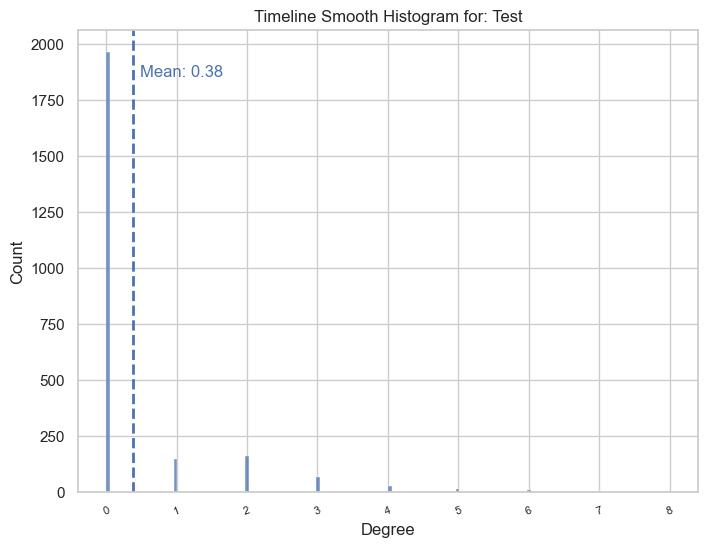

In [98]:
def plot_network_degree_distribution(G, title):
    degrees = np.array([degree for node, degree in G.degree()])
    # Create the histogram with a KDE
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.histplot(degrees, kde=False, bins=150, stat="count")
    # Calculate the mean
    mean_value = np.mean(degrees)

    # Plot a vertical line at the mean value
    plt.axvline(mean_value, color='b', linestyle='--', linewidth=2)
    plt.text(mean_value + 0.1, plt.ylim()[1] * 0.9, 'Mean: {:.2f}'.format(mean_value), color='b')

    plt.title('Timeline Smooth Histogram for: ' + title)
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.xticks(fontsize=8,rotation=20)
    plt.show()
    
    
plot_network_degree_distribution(G,'Test')